# Forecasting Stock Returns with Liquid Neural Networks using the LNN SageMaker Algorithm

**Blog post:** https://fg-research.com/blog/product/posts/lnn-equity-forecasting.html

## 1. Environment set-up

1. This notebook contains elements which render correctly in Jupyter interface. Open this notebook from an Amazon SageMaker Notebook Instance or Amazon SageMaker Studio.
1. Ensure that IAM role used has **AmazonSageMakerFullAccess**
1. Some hands-on experience using [Amazon SageMaker](https://aws.amazon.com/sagemaker/).
1. To use this algorithm successfully, ensure that:
    1. Either your IAM role has these three permissions and you have authority to make AWS Marketplace subscriptions in the AWS account used: 
        1. **aws-marketplace:ViewSubscriptions**
        1. **aws-marketplace:Unsubscribe**
        1. **aws-marketplace:Subscribe**  
    2. or your AWS account has a subscription to the [Time Series Forecasting (LNN) Algorithm from AWS Marketplace](https://aws.amazon.com/marketplace/pp/prodview-7s4giphluwgta).

To subscribe to the algorithm:
1. Open the algorithm listing page.
1. On the AWS Marketplace listing, click on the **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you agree with EULA, pricing, and support terms. 
1. Once you click on the **Continue to configuration** button and then choose a **region**, you will see a **Product ARN**. This is the algorithm ARN that you need to specify while training a custom ML model. **Copy the ARN corresponding to your region and specify the same in the following cell.**

In [1]:
algo_arn = "arn:aws:sagemaker:<...>"

Install the [Yahoo! Finance Python API](https://github.com/ranaroussi/yfinance).

In [2]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 77.7 MB/s eta 0:00:00:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 111.7 MB/s eta 0:00:0000:01
  Created wheel for peewee: filename=peewee-3.17.6-cp310-cp310-linux_x86_64.whl size=279105 sha256=56f737f2da8867ebb657461b42c8decb40b205e26909f018b7f39c430baabd85
  Stored in directory: /home/ec2-user/.cache/pip/wheels/4b/b9/b0/83d6e258e8f963f5ff111a2cd8c483ca59372a86e6a2535212
Successfully built peewee


Set up the SageMaker session.

In [3]:
import io
import sagemaker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, accuracy_score, f1_score

# SageMaker session
sagemaker_session = sagemaker.Session()

# SageMaker role
role = sagemaker.get_execution_role()

# S3 bucket
bucket = sagemaker_session.default_bucket()

# EC2 instance
instance_type = "ml.m5.4xlarge"

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


Define the sequence lengths.

In [4]:
context_length = 30
prediction_length = 30

Define the remaining hyperparameters.

In [5]:
hyperparameters = {
    "context-length": context_length,
    "prediction-length": prediction_length,
    "sequence-stride": 1,
    "hidden-size": 20,
    "backbone-layers": 1,
    "backbone-units": 40,
    "backbone-activation": "lecun",
    "backbone-dropout": 0,
    "minimal": True,
    "no-gate": True,
    "use-mixed": False,
    "use-ltc": False,
    "batch-size": 32,
    "lr": 0.0001,
    "lr-decay": 0.9999,
    "epochs": 800,
}

## 2. Data preparation

Download the data.

In [6]:
tickers = ["^SPX", "^VIX", "^VVIX", "^VXN", "^GVZ", "^OVX"]
dataset = yf.download(" ".join(tickers), start="2022-06-30", end="2024-06-29")

[*********************100%%**********************]  6 of 6 completed


Extract the close prices.

In [7]:
dataset = dataset.loc[:, dataset.columns.get_level_values(0) == "Close"]
dataset.columns = dataset.columns.get_level_values(1)

Forward fill the missing values.

In [8]:
dataset.ffill(inplace=True)

In [9]:
dataset.shape

(502, 6)

In [10]:
dataset.head()

Ticker,^GVZ,^OVX,^SPX,^VIX,^VVIX,^VXN
Date,,,,,,
2022-06-30,19.610001,48.900002,3785.379883,28.709999,89.389999,36.209999
2022-07-01,20.170000,49.400002,3825.330078,26.700001,85.510002,34.270000
2022-07-05,21.330000,52.610001,3831.389893,27.540001,87.300003,34.860001
2022-07-06,21.910000,54.669998,3845.080078,26.730000,85.879997,33.750000
2022-07-07,20.500000,52.869999,3902.620117,26.080000,85.879997,32.810001


In [11]:
dataset.tail()

Ticker,^GVZ,^OVX,^SPX,^VIX,^VVIX,^VXN
Date,,,,,,
2024-06-24,15.49,25.420000,5447.870117,13.33,84.800003,17.240000
2024-06-25,14.88,25.750000,5469.299805,12.84,82.870003,16.700001
2024-06-26,14.88,26.240000,5477.899902,12.55,81.449997,16.500000
2024-06-27,15.01,26.280001,5482.870117,12.24,79.500000,16.290001
2024-06-28,14.72,26.540001,5460.479980,12.44,79.480003,16.240000


Calculate the returns.

In [12]:
dataset["Return30"] = np.log(dataset["^SPX"]).diff(periods=30)

Calculate the realized volatility.

In [13]:
dataset["RVOL"] = np.log(dataset["^SPX"]).diff(periods=1).rolling(window=30).std(ddof=1)

Drop the prices.

In [14]:
dataset.drop(labels=["^SPX"], axis=1, inplace=True)

Drop the missing values.

In [15]:
dataset.dropna(inplace=True)

Move the returns to the first column.

In [16]:
dataset = dataset[["Return30"] + dataset.columns.drop("Return30").tolist()]

Visualize the data.

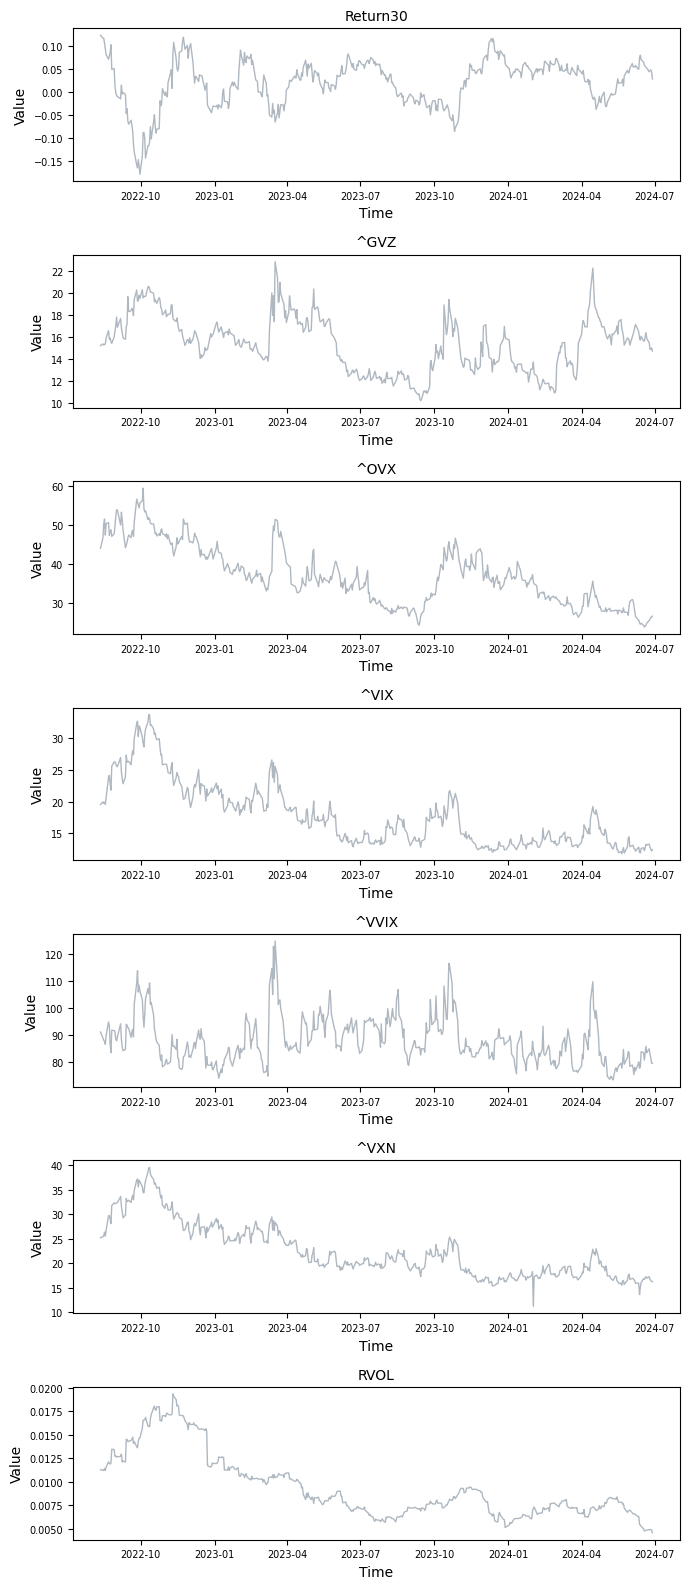

In [17]:
fig, axs = plt.subplots(nrows=dataset.shape[1], ncols=1, sharex=True, figsize=(7, 16))
for i in range(dataset.shape[1]):
    axs[i].plot(dataset.iloc[:, i], color="#AFB8C1", lw=1)
    axs[i].set_title(f"{dataset.columns[i]}", size=10)
    axs[i].set(xlabel="Time", ylabel="Value")
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis="both", which="major", labelsize=7)
    axs[i].tick_params(axis="both", which="minor", labelsize=7)
fig.tight_layout()
fig.show()

Rename the columns.

In [18]:
dataset.columns = ["y"] + [f"x{i}" for i in range(dataset.shape[1] - 1)]

In [19]:
dataset.shape

(472, 7)

In [20]:
dataset.head()

,y,x0,x1,x2,x3,x4,x5
Date,,,,,,,
2022-08-12,0.122842,15.22,44.000000,19.530001,91.010002,25.180000,0.011281
2022-08-15,0.116305,15.37,46.630001,19.950001,88.730003,25.400000,0.011216
2022-08-16,0.116596,15.27,50.250000,19.690001,88.050003,25.549999,0.011214
2022-08-17,0.105765,15.32,51.549999,19.900000,87.470001,26.330000,0.011398
2022-08-18,0.093178,15.36,47.410000,19.559999,86.459999,25.520000,0.011196


In [21]:
dataset.tail()

,y,x0,x1,x2,x3,x4,x5
Date,,,,,,,
2024-06-24,0.043862,15.49,25.420000,13.33,84.800003,17.240000,0.004890
2024-06-25,0.046140,14.88,25.750000,12.84,82.870003,16.700001,0.004911
2024-06-26,0.047952,14.88,26.240000,12.55,81.449997,16.500000,0.004900
2024-06-27,0.044033,15.01,26.280001,12.24,79.500000,16.290001,0.004863
2024-06-28,0.028293,14.72,26.540001,12.44,79.480003,16.240000,0.004567


## 3. Testing

Split the data.

In [22]:
test_size = int(0.3 * len(dataset))

In [23]:
training_dataset = dataset.iloc[:- test_size - context_length - prediction_length - 1]

In [24]:
training_dataset.shape

(270, 7)

In [25]:
print(training_dataset.index.min())
print(training_dataset.index.max())

2022-08-12 00:00:00
2023-09-08 00:00:00


In [26]:
test_dataset = dataset.iloc[- test_size - context_length - prediction_length - 1:]

In [27]:
test_dataset.shape

(202, 7)

In [28]:
print(test_dataset.index.min())
print(test_dataset.index.max())

2023-09-11 00:00:00
2024-06-28 00:00:00


Train the model.

In [29]:
# upload the training data to S3
training_data = sagemaker_session.upload_string_as_file_body(
    body=training_dataset.to_csv(index=False),
    bucket=bucket,
    key="training_data.csv"
)

# create the estimator
estimator = sagemaker.algorithm.AlgorithmEstimator(
    algorithm_arn=algo_arn,
    role=role,
    instance_count=1,
    instance_type=instance_type,
    input_mode="File",
    sagemaker_session=sagemaker_session,
    hyperparameters=hyperparameters
)

# run the training job
estimator.fit({"training": training_data})

INFO:sagemaker:Creating training-job with name: cfc-tsf-v1-7-2024-08-03-19-15-44-813


2024-08-03 19:15:44 Starting - Starting the training job...
2024-08-03 19:15:59 Starting - Preparing the instances for training...
2024-08-03 19:16:36 Downloading - Downloading the training image...............
2024-08-03 19:19:02 Training - Training image download completed. Training in progress....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-08-03 19:19:35,604 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-08-03 19:19:35,605 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-08-03 19:19:35,605 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2024-08-03 19:19:35,606 sagemaker-training-toolkit INFO     Failed to parse hyperparameter backbone-activation value lecun to Json.
Returning the value itself
2024-08-03 19:19:35,615 sagemaker_pytorch_container.training INFO     Block until all host D

Deploy the model.

In [30]:
# define the endpoint inputs serializer
serializer = sagemaker.serializers.CSVSerializer(
    content_type="text/csv"
)

# define the endpoint outputs deserializer
deserializer = sagemaker.base_deserializers.PandasDeserializer(
    accept="text/csv"
)

# create the endpoint
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
    serializer=serializer,
    deserializer=deserializer,
)

INFO:sagemaker:Creating model package with name: cfc-tsf-v1-7-2024-08-03-19-21-58-605


.........

INFO:sagemaker:Creating model with name: cfc-tsf-v1-7-2024-08-03-19-21-58-605


INFO:sagemaker:Creating endpoint-config with name cfc-tsf-v1-7-2024-08-03-19-21-58-605
INFO:sagemaker:Creating endpoint with name cfc-tsf-v1-7-2024-08-03-19-21-58-605


----------!

Generate the test set predictions.

In [31]:
# create a list for storing the predictions
predictions = []

# loop across the dates
for t in range(context_length, len(test_dataset) - prediction_length + 1):

    # extract the inputs
    payload = test_dataset.iloc[t - context_length: t]

    # invoke the endpoint
    response = sagemaker_session.sagemaker_runtime_client.invoke_endpoint(
        EndpointName=predictor.endpoint_name,
        ContentType="text/csv",
        Body=payload.to_csv(index=False)
    )

    # deserialize the endpoint response
    response = deserializer.deserialize(response["Body"], content_type="text/csv")

    # extract the predicted 30-day return
    prediction = response.iloc[-1:]

    # extract the date corresponding to the predicted 30-day return
    prediction.index = [test_dataset.index[t + prediction_length - 1]]

    # save the prediction
    predictions.append(prediction)

# cast the predictions to data frame
predictions = pd.concat(predictions)

# add the actual values
predictions["y"] = test_dataset["y"]

In [32]:
predictions.shape

(143, 3)

In [33]:
predictions.head()

,y_mean,y_std,y
2023-12-04,0.060522,0.019680,0.078645
2023-12-05,0.061875,0.019662,0.079763
2023-12-06,0.061947,0.019010,0.068609
2023-12-07,0.063818,0.019819,0.090989
2023-12-08,0.066189,0.020638,0.106979


In [34]:
predictions.tail()

,y_mean,y_std,y
2024-06-24,0.061514,0.013412,0.043862
2024-06-25,0.061969,0.013349,0.046140
2024-06-26,0.061515,0.013592,0.047952
2024-06-27,0.059986,0.013555,0.044033
2024-06-28,0.059339,0.013293,0.028293


Visualize the test set predictions.

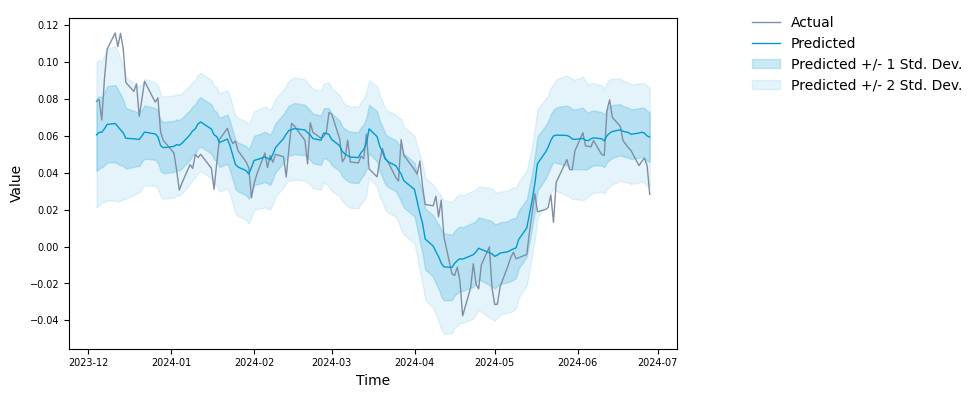

In [35]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(predictions.index, predictions["y"].values, color="#7f8ea3", lw=1, label="Actual")
ax.plot(predictions.index, predictions["y_mean"].values, color="#009ad3", lw=1, label="Predicted")
ax.fill_between(predictions.index, predictions["y_mean"].values + predictions["y_std"].values, predictions["y_mean"].values - predictions["y_std"].values, color="#009ad3", alpha=0.2, lw=1, label="Predicted +/- 1 Std. Dev.")
ax.fill_between(predictions.index, predictions["y_mean"].values + 2 * predictions["y_std"].values, predictions["y_mean"].values - 2 * predictions["y_std"].values, color="#009ad3", alpha=0.1, lw=1, label="Predicted +/- 2 Std. Dev.")
ax.set(xlabel="Time", ylabel="Value")
ax.xaxis.set_tick_params(labelbottom=True)
ax.tick_params(axis="both", which="major", labelsize=7)
ax.tick_params(axis="both", which="minor", labelsize=7)
fig.legend(bbox_to_anchor=(1, 0, 0.4, 1), frameon=False)
fig.tight_layout()
fig.show()

Evaluate the test set predictions.

In [36]:
metrics = pd.DataFrame(
    columns=["Metric", "Value"],
    data=[
        {"Metric": "RMSE", "Value": root_mean_squared_error(y_true=predictions["y"], y_pred=predictions["y_mean"])},
        {"Metric": "MAE", "Value": mean_absolute_error(y_true=predictions["y"], y_pred=predictions["y_mean"])},
        {"Metric": "Accuracy", "Value": accuracy_score(y_true=predictions["y"] > 0, y_pred=predictions["y_mean"] > 0)},
        {"Metric": "F1", "Value": f1_score(y_true=predictions["y"] > 0, y_pred=predictions["y_mean"] > 0)},
    ]
)

In [37]:
metrics

,Metric,Value
0,RMSE,0.017852
1,MAE,0.013938
2,Accuracy,0.958042
3,F1,0.975207


Delete the model.

In [38]:
predictor.delete_model()

INFO:sagemaker:Deleting model with name: cfc-tsf-v1-7-2024-08-03-19-21-58-605


Delete the endpoint.

In [39]:
predictor.delete_endpoint(delete_endpoint_config=True)

INFO:sagemaker:Deleting endpoint configuration with name: cfc-tsf-v1-7-2024-08-03-19-21-58-605
INFO:sagemaker:Deleting endpoint with name: cfc-tsf-v1-7-2024-08-03-19-21-58-605


## 4. Forecasting

Retrain the model using all the available data.

In [40]:
# upload the training data to S3
data = sagemaker_session.upload_string_as_file_body(
    body=dataset.to_csv(index=False),
    bucket=bucket,
    key="dataset.csv"
)

# create the estimator
estimator = sagemaker.algorithm.AlgorithmEstimator(
    algorithm_arn=algo_arn,
    role=role,
    instance_count=1,
    instance_type=instance_type,
    input_mode="File",
    sagemaker_session=sagemaker_session,
    hyperparameters=hyperparameters
)

# run the training job
estimator.fit({"training": data})

INFO:sagemaker:Creating training-job with name: cfc-tsf-v1-7-2024-08-03-19-28-25-202


2024-08-03 19:28:25 Starting - Starting the training job...
2024-08-03 19:28:39 Starting - Preparing the instances for training...
2024-08-03 19:29:25 Downloading - Downloading the training image...............
2024-08-03 19:31:52 Training - Training image download completed. Training in progress......bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-08-03 19:32:31,823 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-08-03 19:32:31,824 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-08-03 19:32:31,825 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2024-08-03 19:32:31,825 sagemaker-training-toolkit INFO     Failed to parse hyperparameter backbone-activation value lecun to Json.
Returning the value itself
2024-08-03 19:32:31,834 sagemaker_pytorch_container.training INFO     Block until all host

Generate the out-of-sample forecasts.

In [41]:
# upload the input data to S3
inputs = sagemaker_session.upload_string_as_file_body(
    body=dataset.iloc[- context_length:].to_csv(index=False),
    bucket=bucket,
    key="inputs.csv"
)

# create the transformer
transformer = estimator.transformer(
    instance_count=1,
    instance_type=instance_type,
)

# run the transform job
transformer.transform(
    data=inputs,
    content_type="text/csv",
)

INFO:sagemaker:Creating model package with name: cfc-tsf-v1-7-2024-08-03-19-36-10-075


.........

INFO:sagemaker:Creating model with name: cfc-tsf-v1-7-2024-08-03-19-36-10-075-2024-08-03-19-36-55-550


INFO:sagemaker:Creating transform job with name: cfc-tsf-v1-7-2024-08-03-19-36-56-242


2024-08-03T19:45:05,526 [WARN ] main org.pytorch.serve.util.ConfigManager - Your torchserve instance can access any URL to load models. When deploying to production, make sure to limit the set of allowed_urls in config.properties
2024-08-03T19:45:05,528 [INFO ] main org.pytorch.serve.servingsdk.impl.PluginsManager - Initializing plugins manager...
2024-08-03T19:45:05,581 [INFO ] main org.pytorch.serve.metrics.configuration.MetricConfiguration - Successfully loaded metrics configuration from /opt/conda/lib/python3.10/site-packages/ts/configs/metrics.yaml
2024-08-03T19:45:05,697 [INFO ] main org.pytorch.serve.ModelServer - 
Torchserve version: 0.11.0
TS Home: /opt/conda/lib/python3.10/site-packages
Current directory: /
Temp directory: /home/model-server/tmp
Metrics config path: /opt/conda/lib/python3.10/site-packages/ts/configs/metrics.yaml
Number of GPUs: 0
Number of CPUs: 16
Max heap size: 15904 M
Python executable: /opt/conda/bin/python3.10
Config file: /etc/sagemaker-ts.properties
In

Load the out-of-sample forecasts from S3.

In [42]:
# download the forecasts from S3
forecasts = sagemaker_session.read_s3_file(
    bucket=bucket,
    key_prefix=f"{transformer.latest_transform_job.name}/inputs.csv.out"
)

# cast the forecasts to data frame
forecasts = pd.read_csv(io.StringIO(forecasts), dtype=float).dropna()

# add the forecast dates
forecasts.index = pd.date_range(
    start=dataset.index[-1] + pd.Timedelta(days=1),
    periods=prediction_length,
    freq=CustomBusinessDay(calendar=USFederalHolidayCalendar())
)

In [43]:
forecasts.shape

(30, 2)

In [44]:
forecasts.head()

,y_mean,y_std
2024-07-01,0.025582,0.013957
2024-07-02,0.026132,0.015080
2024-07-03,0.030058,0.014417
2024-07-05,0.026641,0.014333
2024-07-08,0.030689,0.014129


In [45]:
forecasts.tail()

,y_mean,y_std
2024-08-06,0.048416,0.014952
2024-08-07,0.053644,0.015508
2024-08-08,0.052004,0.016497
2024-08-09,0.057352,0.016347
2024-08-12,0.053550,0.016371


Visualize the out-of-sample forecasts.

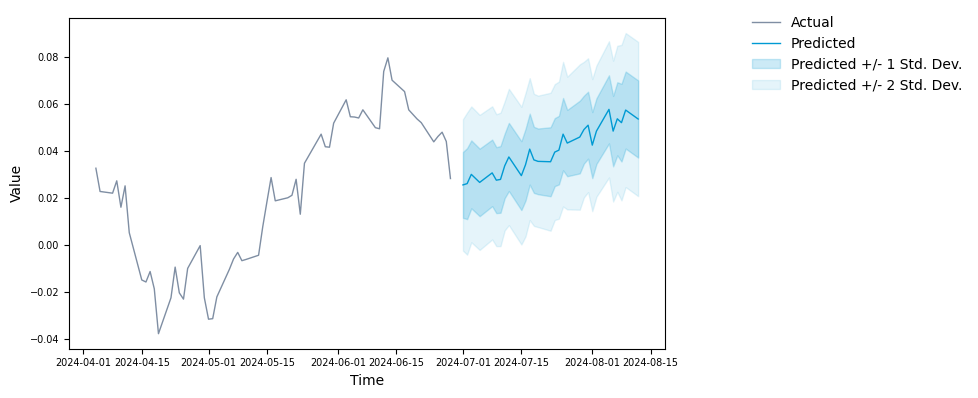

In [46]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(dataset.iloc[- context_length - prediction_length:].index, dataset["y"].iloc[- context_length - prediction_length:].values, color="#7f8ea3", lw=1, label="Actual")
ax.plot(forecasts.index, forecasts["y_mean"].values, color="#009ad3", lw=1, label="Predicted")
ax.fill_between(forecasts.index, forecasts["y_mean"].values + forecasts["y_std"].values, forecasts["y_mean"].values - forecasts["y_std"].values, color="#009ad3", alpha=0.2, lw=1, label="Predicted +/- 1 Std. Dev.")
ax.fill_between(forecasts.index, forecasts["y_mean"].values + 2 * forecasts["y_std"].values, forecasts["y_mean"].values - 2 * forecasts["y_std"].values, color="#009ad3", alpha=0.1, lw=1, label="Predicted +/- 2 Std. Dev.")
ax.set(xlabel="Time", ylabel="Value")
ax.xaxis.set_tick_params(labelbottom=True)
ax.tick_params(axis="both", which="major", labelsize=7)
ax.tick_params(axis="both", which="minor", labelsize=7)
fig.legend(bbox_to_anchor=(1, 0, 0.4, 1), frameon=False)
fig.tight_layout()
fig.show()

Delete the model.

In [47]:
transformer.delete_model()

INFO:sagemaker:Deleting model with name: cfc-tsf-v1-7-2024-08-03-19-36-10-075-2024-08-03-19-36-55-550
